In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


# Review Database

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [4]:
# Collect the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Print column names and data type of 'measurement' table
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Print column names and data type of 'station' table
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Query records in 'measurment' table
measure_data = pd.read_sql("SELECT * FROM measurement",conn)
measure_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [8]:
# Query records in 'station' table
measure_data = pd.read_sql("SELECT * FROM station",conn)
measure_data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Reflect Tables

In [9]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Assign the measurement class to a variable called `measure`
Measure = Base.classes.measurement

# Assign the station class to a variable called `Station`
Station = Base.classes.station

# Create a session
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
# Find last date in 'measurement' table
last_date=session.query(Measure.date).order_by(Measure.date.desc()).first()
last_date

('2017-08-23')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
from_dt=dt.date(2017, 8, 23) - dt.timedelta(days=365)
from_dt

datetime.date(2016, 8, 23)

In [12]:
# Query to retrieve the last 12 months of precipitation data

prcp_data=session.query(Measure.date,Measure.prcp).\
        filter(Measure.date >= from_dt).\
        filter(Measure.prcp != None).\
        order_by(Measure.date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','prcp'])

# Convert 'date' to datetime
prcp_df["date"]=pd.to_datetime(prcp_df["date"])

# Set date as index
prcp_df.set_index('date',inplace=True)
# Sort the dataframe by date
prcp_df=prcp_df.sort_values(['date','prcp'],ascending=True)
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


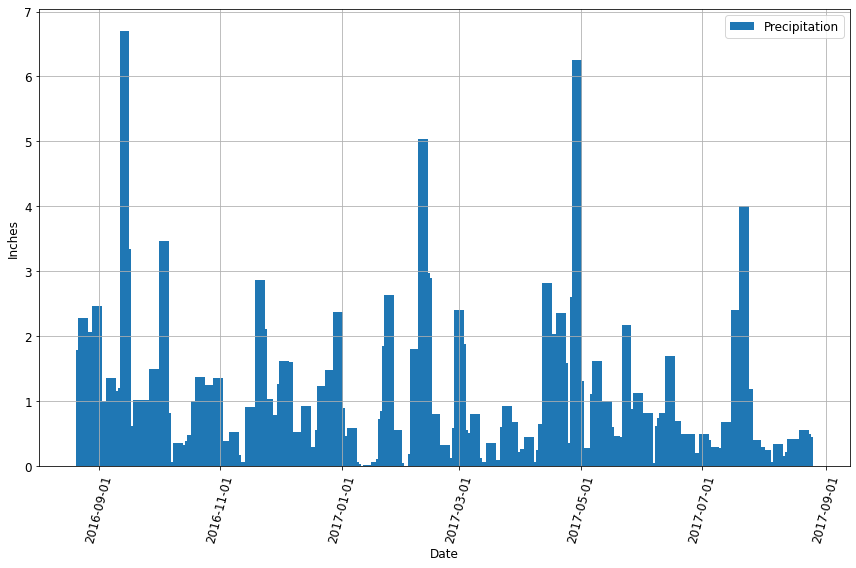

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(prcp_df.index,prcp_df.prcp,width=5)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.legend(["Precipitation"], fontsize=12)
plt.xticks(rotation=75,size=12)
plt.yticks(size=12)

date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
count_station=session.query(func.count(Station.station)).all()
count_station

[(9)]

In [17]:
active_station=session.query(Measure.station).\
                            group_by(Measure.station).\
                            order_by(func.count(Measure.id).desc()).first()
active_station

('USC00519281')

In [18]:
# Method 1
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [Measure.station,
      func.min(Measure.tobs),
      func.max(Measure.tobs),
      func.avg(Measure.tobs),
      func.max(Measure.date)]
session.query(*sel).\
    filter(Measure.station=='USC00519281').\
    group_by(Measure.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067, '2017-08-18')]

In [19]:
# Method 2 - Using pandas
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_active = pd.read_sql("SELECT m.station, s.name \
                           , min(m.tobs) as lowest_temperature \
                           , max(m.tobs) as highest_temperature \
                           , avg(m.tobs) as average_temperature \
                           , max(date) as last_date \
                           FROM measurement m inner join station s\
                           on m.station=s.station \
                           where m.station = 'USC00519281' \
                           group by s.station, s.name",conn)
station_active

,station,name,lowest_temperature,highest_temperature,average_temperature,last_date
0,USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781,2017-08-18


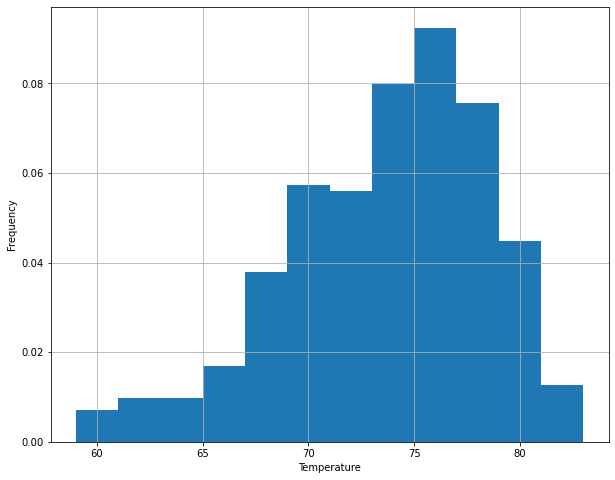

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
from_dt_t=dt.date(2017, 8, 18) - dt.timedelta(days=365)

# Query to retrieve the last 12 months of precipitation data

tobs_data=session.query(Measure.date,Measure.tobs).\
        filter(Measure.date >= from_dt_t).\
        filter(Measure.station == 'USC00519281').\
        order_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(tobs_data,columns=['date','tobs'])

# Convert 'date' to datetime
tobs_df["date"]=pd.to_datetime(tobs_df["date"])

# Set date as index
tobs_df.set_index('date',inplace=True)
# Sort the dataframe by date
tobs_df=tobs_df.sort_values(['date','tobs'],ascending=True)

# Plot histogram
plt.figure(figsize=[10,8])
plt.hist(tobs_df["tobs"], density=True,bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
